<a href="https://colab.research.google.com/github/zach401/acnsim_baseline_comparison/blob/master/baseline_algorithms_w_constrained_infrastructure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%consume
!git clone https://github.com/zach401/acnportal.git

Cloning into 'acnportal'...
remote: Enumerating objects: 628, done.
remote: Counting objects: 100% (628/628), done.
remote: Compressing objects: 100% (294/294), done.
remote: Total 1333 (delta 371), reused 562 (delta 320), pack-reused 705
Receiving objects: 100% (1333/1333), 971.14 KiB | 18.32 MiB/s, done.
Resolving deltas: 100% (835/835), done.


In [4]:
%consume
%cd acnportal
!git pull 
!git checkout experimental
%cd ..
!pip install acnportal/.

/content/acnportal
Already up to date.
Branch 'experimental' set up to track remote branch 'experimental' from 'origin'.
Switched to a new branch 'experimental'
/content
Processing ./acnportal
  Stored in directory: /tmp/pip-ephem-wheel-cache-7nrlccpm/wheels/6d/6a/19/10aef74a8c705c23f53e3e1d696420b07fcdbc88af47701336
Successfully built acnportal


In [0]:
from matplotlib import pyplot as plt
from datetime import datetime
import pytz
import numpy as np
import pandas as pd
from collections import defaultdict
from pprint import pprint
from copy import deepcopy

from acnportal.acnsim import Simulator
from acnportal.acnsim.network.sites import CaltechACN
from acnportal.acnsim.events import acndata_events
from acnportal.acnsim.analysis import *
from acnportal.algorithms import SortedSchedulingAlgo, UncontrolledCharging, RoundRobin
from acnportal.algorithms import earliest_deadline_first, first_come_first_served, least_laxity_first

In [0]:
# -- Experiment Parameters ---------------------------------------------------------------------------------------------
# Timezone of the ACN we are using.
timezone = pytz.timezone('America/Los_Angeles')

# Start and End times are used when collecting data.
start = timezone.localize(datetime(2019, 3, 1))
end = timezone.localize(datetime(2019, 4, 1))
# end = timezone.localize(datetime(2019, 4, 1,))

# How long each time discrete time interval in the simulation should be.
period = 5  # minutes

# Voltage of the network.
voltage = 208  # volts

# Default maximum charging rate for each EV battery.
default_battery_power = 6.6  # kW
site = 'caltech'

# -- Events ------------------------------------------------------------------------------------------------------------
API_KEY = 'DEMO_TOKEN'
events = acndata_events.generate_events(API_KEY, site, start, end, period, voltage, default_battery_power)

In [0]:
results = defaultdict(dict)
sims = defaultdict(dict)

for d in [5, 10, 15, 20, 25, 35, 50, 75, 100, 125, 150]:
    cn = CaltechACN(voltage=voltage, transformer_cap=d)
    sch = {}
    sch['FCFS'] = SortedSchedulingAlgo(first_come_first_served)
    sch['LLF'] = SortedSchedulingAlgo(least_laxity_first)
    sch['EDF'] = SortedSchedulingAlgo(earliest_deadline_first)
    sch['RR'] = RoundRobin(first_come_first_served)
    for sch_alg in sch:
        # Simulator
        sim = Simulator(deepcopy(cn), sch[sch_alg], deepcopy(events),
                        start, period=period, max_recomp=1, verbose=False)
        sim.run()
        obj = proportion_of_energy_delivered(sim)
        results[sch_alg][d] = obj
        sims[sch_alg][d] = sim

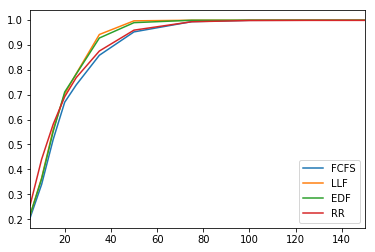

In [21]:
pd.DataFrame(results).plot()

In [0]:
currents = {}
limits = {}
cap = 15
for alg in sims:
  currents[alg] = constraint_currents(sims[alg][cap])
  limits[alg] = {c.name: c.limit for c in sims[alg][cap].network.constraint_set.constraints}

In [0]:
for alg in sims:
  currents[alg]['Total'] = aggregate_current(sims[alg][15])

In [0]:
def plot_currents(name, start, length):
  fig, axes = plt.subplots(3, len(currents), sharey=True, sharex=True, figsize=(5, 6))
  fig.subplots_adjust(wspace=0.07)

  i = 0
  for alg in currents:
    print(alg)
    j = 0
    for line in 'ABC':
      axes[j, i].plot(currents[alg]['{0} {1}'.format(name, line)][start: start + length], label=line)
      axes[j, i].axhline(limits[alg]['{0} {1}'.format(name, line)], color='grey')
      print(sum(currents[alg]['{0} {1}'.format(name, line)][start: start + length]))
      j += 1
    i += 1

FCFS
1258.7242607058479
2249.2485306380936
1325.4784247628
LLF
1435.6057231008367
2289.263511213266
1232.986661180434
EDF
1638.6523155152393
1722.274404424237
1502.905384567957
RR
1431.2159351524122
2361.0738433041142
1580.107211639769


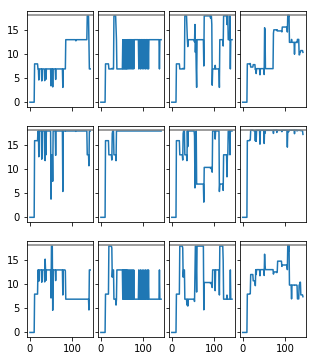

In [12]:
plot_currents('Primary', 1324, 144)

FCFS
4504.877365641077
4611.394285688249
1881.807692307693
LLF
4778.699533914091
4507.743730381884
1989.019230769231
EDF
3961.107993387566
3713.401846834691
3344.667292202608
RR
4801.244527633704
4988.559703844949
2393.893721762003


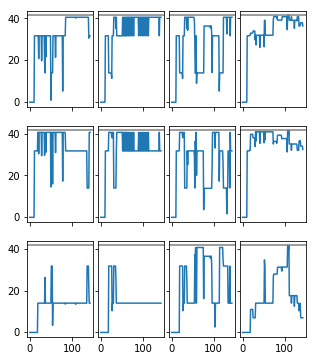

In [13]:
plot_currents('Secondary', 1324, 144)